IMPORT LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob

In [ ]:
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch
from fastai.callbacks.hooks import *
import fastai

In [ ]:
import pickle as pkl

In [ ]:
data_path = "/content/drive/My Drive/computer vision ships classification/images"
path = os.path.join(data_path , "*jpg")

In [ ]:
#files = glob.glob(path) # glob() finds all the pathnames matching a specified pattern and returns them.
#data=[]
#for file in files:
#    image = cv2.imread(file)
#    data.append(image)

In [ ]:
#with open("/content/drive/My Drive/computer vision ships classification/data.pkl", "wb") as f:
#  pkl.dump(data, f)

In [ ]:
with open("/content/drive/My Drive/computer vision ships classification/data.pkl", "rb") as f:
  data = pkl.load(f)

In [ ]:
print(len(data))
print(data[0].shape)
print(data[1].shape)
print(data[2].shape)
print(data[3].shape)
# data is a list of 8985 3d arrays, each array representing an image

8985
(158, 210, 3)
(158, 210, 3)
(118, 210, 3)
(140, 210, 3)


In [ ]:
for i in range(0, 20):
  print(data[i].shape)
# the images are of different shapes - will have to resize them

In [ ]:
data

In [ ]:
train_df = pd.read_csv('/content/drive/My Drive/computer vision ships classification/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/computer vision ships classification/test_ApKoW4T.csv')
submit = pd.read_csv('/content/drive/My Drive/computer vision ships classification/sample_submission_ns2btKE.csv')

In [ ]:
train_df.shape

(6252, 2)

In [ ]:
test_df.shape

(2680, 1)

In [ ]:
submit.shape

(2680, 2)

In [ ]:
train_df.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [ ]:
test_df.head()

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg


In [ ]:
submit.head()

,image,category
0,1007700.jpg,1
1,1011369.jpg,1
2,1051155.jpg,1
3,1062001.jpg,1
4,1069397.jpg,1


In [ ]:
train_df.groupby('category').count()

,image
category,
1,2120
2,1167
3,916
4,832
5,1217


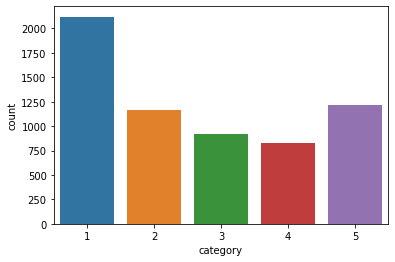

In [ ]:
sns.countplot(x='category' , data=train_df) # analyse number of training data points in each category

In [ ]:
# map the ship categories to numerical values (as given is csv files)
category = {'Cargo': 1, 
'Military': 2, 
'Carrier': 3, 
'Cruise': 4, 
'Tankers': 5}

CREATE TRAIN AND TEST IMAGE LISTS SEPARATELY

In [ ]:
#files = train_df['image']
#train_data=[]
#for file in files:
#    image = cv2.imread(os.path.join(data_path , file))
#    train_data.append(image)

In [ ]:
#with open("/content/drive/My Drive/computer vision ships classification/train_data.pkl", "wb") as f:
#  pkl.dump(train_data, f)

In [ ]:
with open("/content/drive/My Drive/computer vision ships classification/train_data.pkl", "rb") as f:
  train_data = pkl.load(f)

In [ ]:
len(train_data)

6252

In [ ]:
train_data[0].shape

(140, 210, 3)

In [ ]:
test_df.head()

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg


In [ ]:
#files = test_df['image']
#test_data=[]
#for file in files:
#    image = cv2.imread(os.path.join(data_path , file))
#    test_data.append(image)

In [ ]:
#with open("/content/drive/My Drive/computer vision ships classification/test_data.pkl", "wb") as f:
#  pkl.dump(test_data, f)

In [ ]:
with open("/content/drive/My Drive/computer vision ships classification/test_data.pkl", "rb") as f:
  test_data = pkl.load(f)

In [ ]:
test_data[0].shape

(74, 210, 3)

In [ ]:
len(test_data)

2680

PLOT SOME TRAINING PICS OF EACH CATEGORY

In [ ]:
train_df.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [ ]:
def plot_ships():
  for i in range(1,6):
    img_name = train_df[train_df['category'] == i][0]
    plt.imshow(os.path.join(data_path, img_name))
    plt.xlabel(i)
    plt.show()

WORKING WITH FAST.AI

In [ ]:
# The vision module of the fastai library contains all the necessary functions to define a Dataset and train a model for computer
# vision tasks. It contains four different submodules to reach that goal:

# 1. vision.image contains the basic definition of an Image object and all the functions that are used behind the scenes to
# apply transformations to such an object.

# 2. vision.transform contains all the transforms we can use for data augmentation.
# vision.data contains the definition of ImageDataBunch as well as the utility function to easily build a DataBunch for Computer Vision
# problems.

# 3. vision.learner lets you build and fine-tune models with a pretrained CNN backbone or train a randomly initialized model from 
# scratch.

In [ ]:
# STEPS INVOLVED (in using datablock api):-
# 1. Provide inputs using ItemList class (optionally, filter the data)
# 2. Split the data b/w training and validation set
# 3. Label the inputs (optionally, add transforms and test set)
# 4. convert to databunch

In [ ]:
# STEP 1

# https://docs.fast.ai/vision.data.html#ImageList.from_df

# First, dataset needs to be converted to DataBunch object. (In case of computer vision data, specifically into ImageDataBunch object) 
# This is done with the help of data block API and ImageList class as its subclasses.
# However, there is also a group of shortcut methods provided by ImageDataBunch which reduces the multiple stages of data block api 
# into a single wrapper method. These are :-
# 1. ImageDataBunch.from_folder() -> works well for Imagenet style of datasets
# 2. ImageDataBunch.from_df() -> a pandas dataframe with a column of filenames and a column of labels which can be strings for
# classification, strings separated by a label_delim for multi-classification or floats for a regression problem.
# 3. ImageDataBunch.from_csv() -> a csv file with the same format as above.
# 4. ImagedataBunch.from_lists() -> a list of filenames and a list of targets.
# 5. ImageDataBunch.from_name_func() -> a list of filenames and a function to get the target from the filename.
# 6. ImageDataBunch.from_name_re() -> a list of filenames and a regex pattern to get the target from the filename.
# In the last five methods, a random split is performed between train and validation. In the first, it can be a random split or a
# separation from a training and validation folder.

# from_df() -> from_df(path:PathOrStr, df:DataFrame, folder:PathOrStr=None, label_delim:str=None, valid_pct:float=0.2, 
#                      seed:int=None, fn_col:IntsOrStrs=0, label_col:IntsOrStrs=1, suffix:str='', **kwargs:Any) → ImageDataBunch


In [ ]:
# STEP 2

# SPLIT THE DATA BETWEEN TRAINING AND VALIDATION SETS
# https://docs.fast.ai/data_block.html#Step-2:-Split-the-data-between-the-training-and-the-validation-set
# just pick one of the following functions which are suited to the case :-
# 1. split_none() -> dont split data and create empty validation set.
# 2. split_by_rand_pct(valid_pct = 0.2) -> split the items randomly by putting valid_pct in the validation set.
# 3. split_subsets() -> split the items into a train set with size train_size*n and valid_set with size valid_size*n. This function 
# is handy if you want to work with subsets of specific sizes, e.g., you want to use 20% of the data for the validation dataset,
# but you only want to train on a small subset of the rest of the data: split_subsets(train_size=0.08, valid_size=0.2).
# 4. split_by_files(valid_names : ItemList) -> split by using names in valid_names for validation.
# 5. split_by_fname_file(fnames:PathOrString) -> split the data by using names in fname set for the validation set. Internally makes
# a call to split_by_files. fname contains your image file names like 0001.png.
# 6. split_by_folder() -> spli the data depending on the folder(train OR valid) in which filenames are.Basically, split_by_folder takes 
# in two folder names ('train' and 'valid' in the following example), to split the large ImageList into two smaller ImageLists, 
# one for training set and the other for validation set. Both ImageLists are attached to a large ItemLists which is the final
# output of split_by_folder.

PREPROCESSING

In [ ]:
# The pictures are of varying sizes - will have to make sure they are of same size before modelling.

In [ ]:
# The number of images in the given dataset is quite less. If we train the model using just these images, the deep learning model will 
# most likely overfit. So, will use data augmentation and tranfer learning.

In [ ]:
# DATA AUGMENTATION (regularization technique for computer vision) - instead of feeding our model with the same pictures every time, we 
# perform some small random transformations (a bit of rotation, translation, zoom, etc) that dont change the picture as is perceived by 
# the human eye but changes the pixel values. Models trained this way generalize better.

In [ ]:
# will use fast.ai datablock API to create databunch and train model using CNN.
# fast.ai library provides a convenient method for training image classifier models using CNNs.

In [ ]:
# get_transforms() (of fast.ai library) returns a tuple of two lists of transforms: one for the training set and one for the validation 
# set (we don't want to modify the pictures in the validation set, so the second list of transforms is limited to resizing the pictures).
# This can be passed directly to define a DataBunch object (see below) which is then associated with a model to begin training.

# https://docs.fast.ai/vision.transform.html
# https://course.fast.ai/index.html

In [ ]:
# mixup technique - we do not train directly on raw images. Instead, the model is trained on mixes of images. For example, we can add 
# 2 or more images to get a single image like this : new_image = t * image1 + (1-t) * image2 (can do this with more images also). 
# By using the same technique, the correspondig targets for these images are changed as well : new_target = t * target1 + (1-t) * target2.
# (t is a float between 0 and 1)

In [ ]:
# DATA augmentation parameters for get_transforms() :-

# do_flip -> horizontal flipping - try with both true and false

# flip_vert -> vertical flipping - wont do since ships will get inverted (doing this would make sense if say the images were taken
# from above, like satellite images)

# max_rotate -> true

# max_zoom -> zoom a littel bit since the ships seem to cover less portion of the whole image.

# max_lighting -> true

# max_warp -> warping - wont perform since there is only a slight difference between different categories of ships and warping
# could lead to incorrect predictions.

# p_affine 

# p_lighting 

In [ ]:
# define the transformations to be done to the images:
tfms=get_transforms(do_flip=True,flip_vert=False,max_rotate=10.0,max_zoom=1.1,max_lighting=0.2,max_warp=0.2,p_affine=0.75,p_lighting=0.75)

CREATE DATABUNCH OF TEST SET TO BE PASSED

In [ ]:
# the datablock api lets us customize the creation of a DataBunch by isolating the underlying parts of that process in separate blocks.


# create databunch of test set to be passed
test_img = ImageList.from_df(test_df, path = '/content/drive/My Drive/computer vision ships classification/', folder='images')

In [ ]:
type(test_img)

fastai.vision.data.ImageList

In [ ]:
test_img

ImageList (2680 items)
Image (3, 74, 210),Image (3, 158, 210),Image (3, 140, 210),Image (3, 158, 122),Image (3, 140, 210)
Path: /content/drive/My Drive/computer vision ships classification

CREATE SOURCE OF TRAIN IMAGE DATABUNCH and also add transformations and test set to it

In [ ]:
np.random.seed(145)
# create source of train image databunch
src = (ImageList.from_df(train_df, path = "/content/drive/My Drive/computer vision ships classification/", folder = "images"))

In [ ]:
src

ImageList (6252 items)
Image (3, 140, 210),Image (3, 139, 210),Image (3, 118, 210),Image (3, 88, 210),Image (3, 158, 210)
Path: /content/drive/My Drive/computer vision ships classification

In [ ]:
src = src.split_by_rand_pct(0.2)

In [ ]:
src

ItemLists;

Train: ImageList (5002 items)
Image (3, 140, 210),Image (3, 139, 210),Image (3, 118, 210),Image (3, 88, 210),Image (3, 158, 210)
Path: /content/drive/My Drive/computer vision ships classification;

Valid: ImageList (1250 items)
Image (3, 140, 210),Image (3, 140, 210),Image (3, 141, 210),Image (3, 139, 210),Image (3, 118, 210)
Path: /content/drive/My Drive/computer vision ships classification;

Test: None

In [ ]:
src = src.label_from_df()

In [ ]:
src

LabelLists;

Train: LabelList (5002 items)
x: ImageList
Image (3, 140, 210),Image (3, 139, 210),Image (3, 118, 210),Image (3, 88, 210),Image (3, 158, 210)
y: CategoryList
1,1,2,3,2
Path: /content/drive/My Drive/computer vision ships classification;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 140, 210),Image (3, 140, 210),Image (3, 141, 210),Image (3, 139, 210),Image (3, 118, 210)
y: CategoryList
5,1,1,5,3
Path: /content/drive/My Drive/computer vision ships classification;

Test: None

In [ ]:
src = src.add_test(test_img)

In [ ]:
src

LabelLists;

Train: LabelList (5002 items)
x: ImageList
Image (3, 140, 210),Image (3, 139, 210),Image (3, 118, 210),Image (3, 88, 210),Image (3, 158, 210)
y: CategoryList
1,1,2,3,2
Path: /content/drive/My Drive/computer vision ships classification;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 140, 210),Image (3, 140, 210),Image (3, 141, 210),Image (3, 139, 210),Image (3, 118, 210)
y: CategoryList
5,1,1,5,3
Path: /content/drive/My Drive/computer vision ships classification;

Test: LabelList (2680 items)
x: ImageList
Image (3, 74, 210),Image (3, 158, 210),Image (3, 140, 210),Image (3, 158, 122),Image (3, 140, 210)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/computer vision ships classification

In [ ]:
# define the transformations to be done to the images:
tfms=get_transforms(do_flip=True,flip_vert=False,max_rotate=10.0,max_zoom=1.1,max_lighting=0.2,max_warp=0.2,p_affine=0.75,p_lighting=0.75)

In [ ]:
src = src.transform(tfms, size  =299, padding_mode = 'reflection', resize_method = ResizeMethod.SQUISH)

In [ ]:
src

LabelLists;

Train: LabelList (5002 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
1,1,2,3,2
Path: /content/drive/My Drive/computer vision ships classification;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
5,1,1,5,3
Path: /content/drive/My Drive/computer vision ships classification;

Test: LabelList (2680 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/computer vision ships classification

CREATE THE FINAL DATABUNCH

In [ ]:
# vision.transform -> fast.ai library for complete image transformation written from scratch in pytorch. 
# 1. get_transforms() -> for data augmentation
# 2. zoom_crop() -> to randomly zoom and/or crop
# 3. rand_resize_crop(size, max_scale, ratios) -> Randomly resize and crop the image to a ratio in ratios after a zoom of max_scale.

In [ ]:
data = src.databunch(path='.', bs=32)

In [ ]:
data

ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
1,1,2,3,2
Path: /content/drive/My Drive/computer vision ships classification;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
5,1,1,5,3
Path: /content/drive/My Drive/computer vision ships classification;

Test: LabelList (2680 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/computer vision ships classification

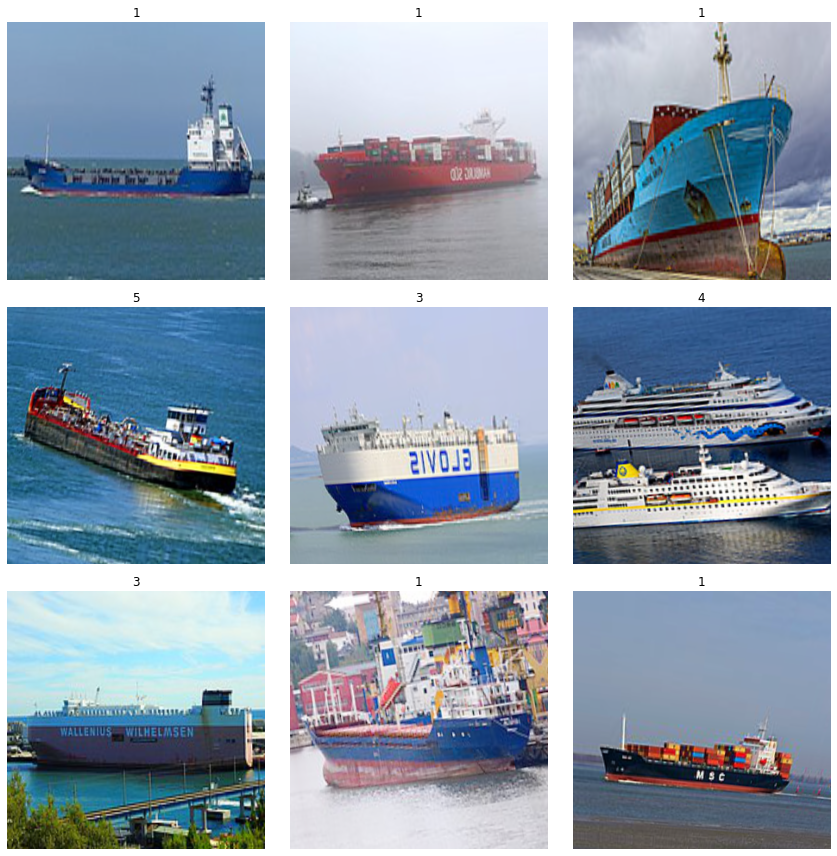

In [ ]:
## lets see the few images from our databunch
data.show_batch(rows=3, figsize=(12,12))

In [ ]:
print(data.classes)

[1, 2, 3, 4, 5]


CREATE THE CNN LEARNER

In [ ]:
# vision.learner library defines the cnn learner method, to easily get a model suitable for transfer learning. 
# The cnn_learner factory method helps us automatically get a pretrained model from a given architecture with a custom head that is
# suitable for our data.

# function (to build convnet style learner) signature :-
# cnn_learner(data:DataBunch, base_arch:Callable, cut:Union[int, Callable]=None, pretrained:bool=True, lin_ftrs:Optional[Collection[int]]
# =None, ps:Floats=0.5, custom_head:Optional[Module]=None, split_on:Union[Callable, Collection[ModuleList], NoneType]=None,
#  bn_final:bool=False, init='kaiming_normal_', concat_pool:bool=True, **kwargs:Any) → Learner

# This method creates a Learner object from data object and model inferred from it with the backbone given in base_arch. 
# Specifically, it will cut the model defined by base_arch(randomly initialized if pretrained is False) at the last conv layer by default
# and add :-
# 1. an AdaptiveConcatPool2d layer
# 2. a Flatten layer
# 3. blocks of [nn.BatchNorm1d, nn.Dropout, nn.Linear, nn.ReLU] layers

# The blocks are defined by lin_ftrs and ps arguments. Specifically, the first block will have number of inputs inferred from the 
# backbone base_arch and the last one will have number of outputs equal to data.c(which contains number of classes of the data) and the 
# intermediate blocks will have number of inputs/outputs determined by lin_ftrs(of course, a block will have number of inputs equal
# to the number of outputs of the previous block).The default is to have an intermediate hidden size of 512 (which makes 2 blocks :
# model_activation -> 512 -> n_classes). If we pass a float, then the final dropout layer will have the value ps, and the remaining 
# will be ps/2. If we pass a list, then the values are used for dropout probabilities directly.
# The last block doesnt have a nn.RelU activation, so we can use any activation function we need (generally included in the loss
# function in pytorch). Also, the bckcone will be frozen if we choose pretrained = True (so only the head will train if we call fit).

# Alternatively, we can also define our own custom_head to put on top of the backbone. To specify where to split the base_arch, can use
# the cut argument. Value for this argument can either be the index of a specific layer(result wont include the layer) or a function that,
# when passed the model, will retur the backbone.

# The final model obtained by stacking the backbone and the head is then separated in groups for gradual unfreezing or differential
# learning rates. Can specify how to split the backcone in groups with the optional argument split_on (should be a function that returns
# those groups when given the backbone).

In [ ]:
# try learner with resnet101
learn = cnn_learner(data=data, base_arch=models.resnet101,metrics=[FBeta(beta=1, average='macro'),accuracy],callback_fns=ShowGraph)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [ ]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
1,1,2,3,2
Path: /content/drive/My Drive/computer vision ships classification;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
5,1,1,5,3
Path: /content/drive/My Drive/computer vision ships classification;

Test: LabelList (2680 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/computer vision ships classification, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(ke

MODEL FITTING PARAMETRS

###TRY 1

1. lr_find() - LEARNING RATE FINDER

In [ ]:
# 1. First run lr_find -> learn.lr_find()
# 2. Plot the learning rate vs loss -> learn.recorder.plot()
# 3. Pick a learning rate before it diverges then start training

epoch,train_loss,valid_loss,f_beta,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-04
Min loss divided by 10: 5.75E-03


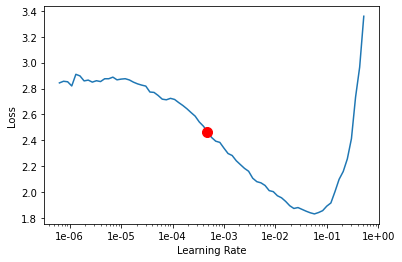

In [ ]:
# learning rate finder plots lr vs loss relationship for a learner. The idea is to reduce the amount of guesswork on picking a good
# starting learning rate. If we pass suggestion = True in learn.recorder.plot, it will show where the gradient is the steepest with a 
# red dot on the graph. We can use this point as the first guess for lr.
learn.lr_find()
learn.recorder.plot(suggestion = True)

# RESULTS :-
# LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
# Min numerical gradient: 1.45E-03
# Min loss divided by 10: 4.79E-03

# LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
# Min numerical gradient: 2.51E-03
# Min loss divided by 10: 6.92E-03

2. fit_one_cycle()

In [ ]:
# fit a model following the Leslie Smiths 1cycle policy. 
# The original 1cycle policy has 3 steps :-
# 1. We progressively increase our learning rate from lr_max/div_factor to lr_max and at the same time we progressively decrease our
# momentum from mom_max to mom_min.
# 2. We do the exact opposite : we progressively decrease our lr from lr_max to lr_max/div_factor and at the same time progressively
# increase momentum from mom_min to mom_max.
# 3. We further decrease our lr from lr_max/div_factor to lr_max/(div_factor*100) and keep the momentum steady at mom_max.

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,1.125290,0.527384,0.830212,0.820800,30:06
1,0.746754,0.485569,0.863002,0.855200,04:12
2,0.605677,0.354245,0.884441,0.873600,04:12
3,0.481211,0.304222,0.905490,0.893600,04:12
4,0.319191,0.258873,0.914792,0.905600,04:12
5,0.297041,0.227110,0.923022,0.915200,04:12
6,0.258605,0.210107,0.933579,0.926400,04:12
7,0.221095,0.198246,0.930969,0.924000,04:12
8,0.172829,0.171868,0.937630,0.932000,04:12
9,0.164285,0.167155,0.948783,0.942400,04:12


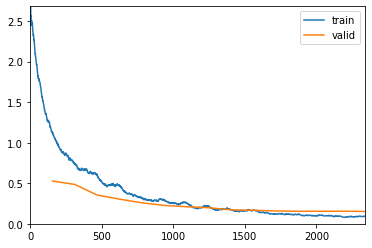

In [ ]:
#lets start with steepest slope point. adding wd (weight decay) not to overfit as we are running 15 epochs 
lr = 1e-03
#learn.fit_one_cycle(10, slice(lr))
learn.fit_one_cycle(15, slice(lr), wd=0.2)

In [ ]:
learn.save('/content/drive/My Drive/computer vision ships classification/classifier-1', return_path = True)

PosixPath('/content/drive/My Drive/computer vision ships classification/classifier-1.pth')

###TRY 2

In [ ]:
# load previously saved model ( ie, model trained in try 1)
learn = learn.load("/content/drive/My Drive/computer vision ships classification/classifier-1")

In [ ]:
# unfreeze the entire model now. This sets every layer group to trainable. (ie, requires_grad = True)
learn.unfreeze()

epoch,train_loss,valid_loss,f_beta,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 1.58E-07


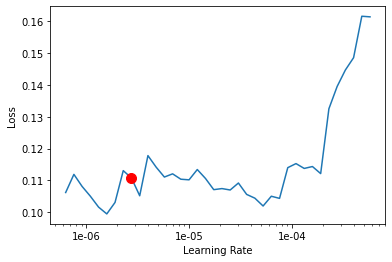

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.095571,0.159979,0.949694,0.944000,05:34
1,0.097546,0.159816,0.949047,0.943200,05:34
2,0.106709,0.154715,0.950521,0.944800,05:34
3,0.089001,0.154435,0.950808,0.945600,05:35
4,0.093368,0.151724,0.949601,0.944000,05:34
5,0.096135,0.154422,0.952945,0.947200,05:34
6,0.084274,0.153221,0.950604,0.944800,05:34
7,0.089365,0.153040,0.952891,0.947200,05:35
8,0.087596,0.151892,0.951129,0.944800,05:34
9,0.085355,0.153464,0.952836,0.947200,05:34


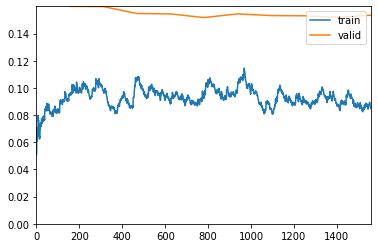

In [ ]:
# train for more cycles after unfreezing
#learn.fit_fit_one_cycle(10,slice(1e-05,lr/8), wd=0.15)
#learn.fit_one_cycle(10, slice(5e-06, lr/8))
lr = 1e-06
learn.fit_one_cycle(10, slice(lr), wd=0.2)

In [ ]:
learn.save('/content/drive/My Drive/computer vision ships classification/classifier-2', return_path = True)

PosixPath('/content/drive/My Drive/computer vision ships classification/classifier-2.pth')

###TRY 3

In [ ]:
# load previously saved model ( ie, model trained in try 2)
learn = learn.load("/content/drive/My Drive/computer vision ships classification/classifier-2")

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,f_beta,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 6.31E-06


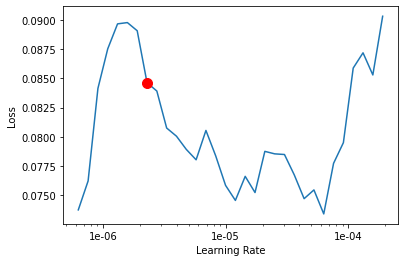

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.091203,0.150009,0.948190,0.942400,05:35
1,0.080929,0.145180,0.952763,0.947200,05:35
2,0.086780,0.139177,0.953744,0.949600,05:35
3,0.076777,0.139899,0.954876,0.949600,05:35
4,0.079182,0.135235,0.955436,0.951200,05:35


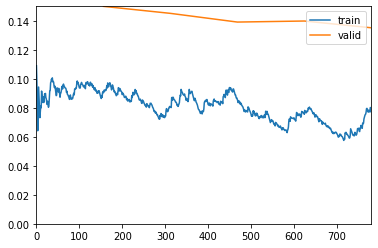

In [ ]:
learn.fit_one_cycle(5,slice(1e-05,1e-06), wd=0.15)

In [ ]:
learn.save('/content/drive/My Drive/computer vision ships classification/classifier-3', return_path = True)

PosixPath('/content/drive/My Drive/computer vision ships classification/classifier-3.pth')

###TRY 4

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.077285,0.133997,0.956550,0.952800,05:35
1,0.062113,0.123285,0.955961,0.951200,05:35
2,0.058858,0.125680,0.960337,0.956000,05:35
3,0.053091,0.125594,0.961415,0.957600,05:35
4,0.052621,0.125416,0.958971,0.955200,05:35


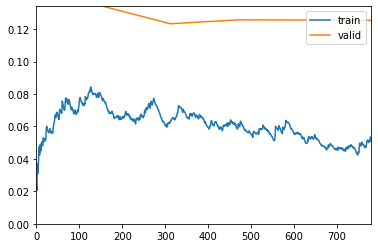

In [ ]:
learn.fit_one_cycle(5,slice(1e-05,1e-06), wd=0.15)

In [ ]:
learn.save('/content/drive/My Drive/computer vision ships classification/classifier-4', return_path = True)

PosixPath('/content/drive/My Drive/computer vision ships classification/classifier-4.pth')

###TRY 5

In [ ]:
learn.load('/content/drive/My Drive/computer vision ships classification/classifier-4')

In [ ]:
# freeze all the layers except last 3 as these are the initial layers for finding recurringpattern/shapes/corners and not specifically for
# finding ships. 
learn.freeze_to(-3)

epoch,train_loss,valid_loss,f_beta,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.10E-07


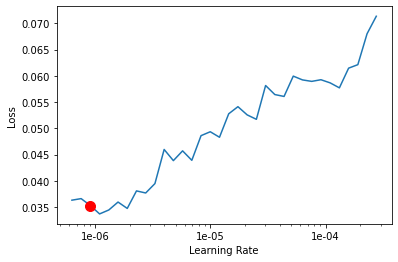

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
# train for a few more cycles (will set 2 LRs for training : one for training the initial layers and one for training the final layers).
# As initial layer stats are imagenet stats which are helpful in finding patterns and not the exact ships,  will train those layers
# with a low LR.

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.055633,0.122022,0.961682,0.957600,30:25
1,0.052041,0.122623,0.962000,0.958400,05:53
2,0.051758,0.122711,0.960613,0.957600,05:53
3,0.044571,0.123653,0.961107,0.957600,05:53
4,0.051640,0.121710,0.961502,0.957600,05:53
5,0.052904,0.119491,0.962685,0.959200,05:53


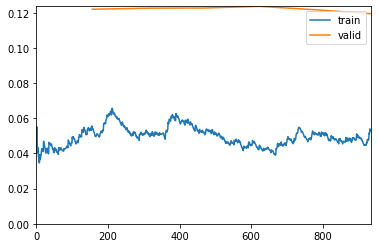

In [ ]:
learn.fit_one_cycle(6, slice(1e-06, (1e-06)/10),wd=0.1)

In [ ]:
learn.save('/content/drive/My Drive/computer vision ships classification/classifier-5', return_path = True)

PosixPath('/content/drive/My Drive/computer vision ships classification/classifier-5.pth')

###TRY 6

In [ ]:
learn.load('/content/drive/My Drive/computer vision ships classification/classifier-5')

In [ ]:
## freezing initial all layers except last 2 layers
learn.freeze_to(-2)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.052238,0.120981,0.960361,0.956000,29:52
1,0.046646,0.121120,0.962030,0.958400,05:23
2,0.044426,0.116554,0.964848,0.961600,05:22
3,0.055205,0.128987,0.959780,0.956000,05:23
4,0.044715,0.119143,0.960036,0.956000,05:23
5,0.054853,0.118236,0.962879,0.959200,05:23


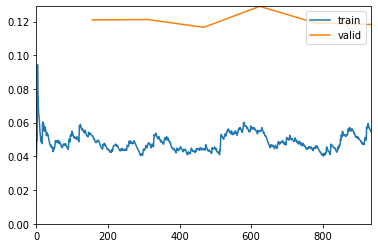

In [ ]:
## training for few cycles more
learn.fit_one_cycle(6, slice(5e-07, (5e-07)/20),wd=0.1)

In [ ]:
learn.save('/content/drive/My Drive/computer vision ships classification/classifier-6', return_path = True)

PosixPath('/content/drive/My Drive/computer vision ships classification/classifier-6.pth')

###TRY 7

In [ ]:
learn.freeze_to(-1)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.046030,0.119966,0.962268,0.958400,04:24
1,0.050726,0.119564,0.962742,0.959200,04:24
2,0.046647,0.121262,0.961460,0.957600,04:24
3,0.046682,0.119016,0.962203,0.958400,04:24
4,0.054443,0.120272,0.961163,0.956800,04:24


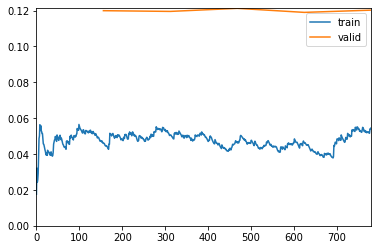

In [ ]:
## training even more
learn.fit_one_cycle(5, slice(1e-07),wd=0.05)

In [ ]:
learn.save('/content/drive/My Drive/computer vision ships classification/classifier-7', return_path = True)

PosixPath('/content/drive/My Drive/computer vision ships classification/classifier-7.pth')

INTERPRETATION

In [ ]:
learn.load('/content/drive/My Drive/computer vision ships classification/classifier-7')

In [ ]:
# ClassificationInterpretation functions :-
# 1. from_learner() -> create an instance of ClassificationInterpretation 
# 2. plot_top_losses() -> Show images in top_losses along with their prediction, actual, loss, and probability of actual class
# 3. plot_multi_top_losses() -> Similar to plot_top_losses() but aimed at multi-labeled datasets.

In [ ]:
interpretation = ClassificationInterpretation.from_learner(learn)

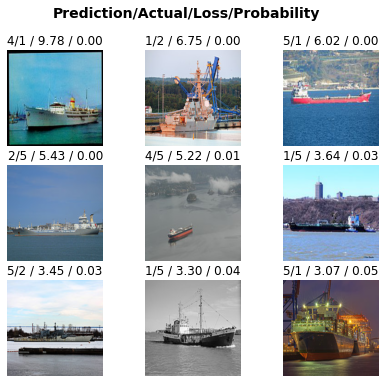

In [ ]:
# see the most misclassified images on validation dataset.
interpretation.plot_top_losses(9, figsize = (7,6))

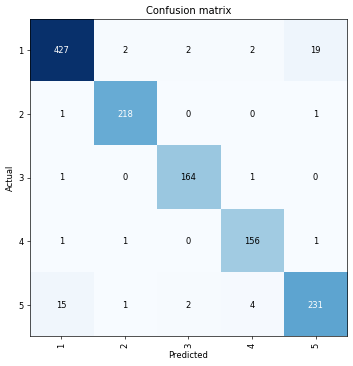

In [ ]:
interpretation.plot_confusion_matrix(figsize=(6,6), dpi=60) # on validation set
# observation -> our model is confusing between category 1 and 5

In [ ]:
interpretation.most_confused(min_val=4) # on validation set

[(1, 5, 19), (5, 1, 15), (5, 4, 4)]

In [ ]:
# end
# best accuracy obtained : 95.92%